# Init

In [130]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display as disp
import numpy as np
from matplotlib import style; style.use('seaborn-whitegrid')
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import scipy.stats as st
from scipy.spatial.distance import euclidean, cosine
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

def ci95(a, i=.95):
    dfs = np.sum(~np.isnan(a), axis=0) - 1
    means = np.nanmean(a, axis=0)
    sems = st.sem(a, axis=0, nan_policy='omit')
    zl = zip(dfs, means, sems)
    return np.stack([st.t.interval(alpha=i, df=d, loc=m, scale=s) for d, m, s in zl]).T


def line(label, **kwargs):
    return Line2D([0], [0], label=label, **kwargs)


def patch(label, **kwargs):
    return Patch(label=label, **kwargs)


in_path = '../data/clean/trials/clean_pilot_trials.csv'
df = pd.read_csv(in_path)
df['init_dist_cond'] = np.abs(df.init_site - df.plat_site)
dur_df = df.groupby(['init_dist_cond', 'outcome'])[['time_trial']].agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in dur_df.index:
    m, c, s = dur_df.loc[i]
    ci95_hi.append(m + 1.96*s/np.sqrt(c))
    ci95_lo.append(m - 1.96*s/np.sqrt(c))

dur_df['ci95_hi'] = ci95_hi
dur_df['ci95_lo'] = ci95_lo
# dur_df.columns = dur_df.columns.get_level_values(0)
print(dur_df.reset_index().to_latex(index=False, float_format='{:0.2f}'.format))

\begin{tabular}{rlrrrrr}
\toprule
init\_dist\_cond &   outcome & \multicolumn{3}{l}{time\_trial} & ci95\_hi & ci95\_lo \\
               &       mean & count & \multicolumn{3}{l}{std} \\
\midrule
             1 &     crash &      15.68 &  1583 & 11.91 &   16.27 &   15.09 \\
             1 & offscreen &      11.20 &   746 &  9.21 &   11.86 &   10.54 \\
             1 &   success &      21.80 &   680 & 10.17 &   22.57 &   21.04 \\
             2 &     crash &      15.99 &   998 & 12.08 &   16.74 &   15.24 \\
             2 & offscreen &      10.56 &   649 & 10.31 &   11.35 &    9.76 \\
             2 &   success &      24.06 &   442 & 11.98 &   25.18 &   22.95 \\
\bottomrule
\end{tabular}



# Aligned trajectories

3153/5098 = 0.6184778344448804% of trials are less than 800 frames


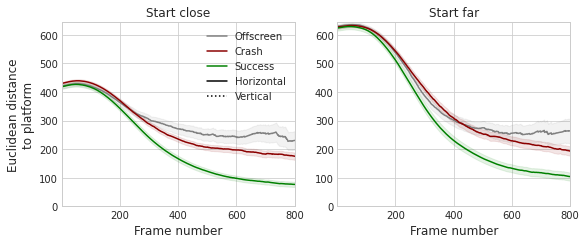

In [286]:
def trajectories2d(data, which=None):
    # Get x, y positions and platform coordinates
    pos_y = np.array(data['y_trail'].split(',')).astype(int)
    plat_y = data['plat_y']
    pos_x = np.array(data['x_trail'].split(',')).astype(int)
    plat_x = data['plat_x']

    # Invert x-axis if lander initiates to the left of the platform
    if pos_x[0] > plat_x:
        pos_x = 800 - pos_x
        plat_x = 800 - plat_x
        
    disp_y, disp_x = plat_y - pos_y, plat_x - pos_x
    disp2d = np.sqrt(disp_y**2 + disp_x**2)

    vel_y, vel_x = num_der(disp_y), num_der(disp_x)
    vel2d = np.sqrt(vel_y**2 + vel_x**2)
    vel2d = np.abs(num_der(disp2d))

    acc_y, acc_x = num_der(vel_y), num_der(vel_x)
    acc2d = np.sqrt(acc_y**2 + acc_x**2)
    return {'disp': disp2d, 'vel': vel2d, 'acc': acc2d}


def pad0(arr):
    return np.array(arr.tolist() + [arr[-1]])


def num_der(x):
    x_ = pad0(x)
    return x_[:-1] - x_[1:]


def aligned_motion_trajectories(df, n, start=True):
    arr = np.full([df.shape[0], n], np.nan)
    return_dict = {'disp': arr.copy(), 'vel': arr.copy(), 'acc': arr.copy()}
    for i, (_, r) in enumerate(df.iterrows()):
        fulls = trajectories2d(r)

        for k, v in fulls.items():
            return_dict[k][i, :v.size] = v[:n] if start else v[-n:]

    return return_dict


def aligned_distance_trajectories(df, n, start=True):
    arr = np.full([df.shape[0], n], np.nan)
    return_dict = {'x': arr.copy(), 'y': arr.copy()}
    for i, (_, r) in enumerate(df.iterrows()):
        for d in 'xy':
            dist = np.abs(np.array(r[f'{d}_trail'].split(',')).astype(int) - r[f'plat_{d}'])
            dist = dist[:n] if start else dist[-n:]
            return_dict[d][i, :dist.size] = dist
    return return_dict


def aligned_speed_trajectories(df, n, start=True):
    arr = np.full([df.shape[0], n], np.nan)
    return_dict = {'x': arr.copy(), 'y': arr.copy()}
    for i, (_, r) in enumerate(df.iterrows()):
        for d in 'xy':
            speed = np.array(r[f'{d}_displ'].split(',')).astype(float)
            speed = speed[:n] if start else speed[-n:]
            return_dict[d][i, :speed.size] = speed
    return return_dict


def aligned_angle_trajectories(df, n, start=True):
    z = 0.000001
    return_dict = {'x': np.full([df.shape[0], n], np.nan)}
    for i, (_, r) in enumerate(df.iterrows()):
        dist_x = np.abs(np.array(r['x_trail'].split(',')).astype(int) - r[f'plat_x'])
        dist_y = np.abs(np.array(r['y_trail'].split(',')).astype(int) - r[f'plat_y'])
        angle = np.degrees(np.arctan((dist_x+z)/(dist_y+z)))
        angle = angle[:n] if start else angle[-n:]
        return_dict['x'][i, :angle.size] = angle
    return return_dict


align_to = 'start' # 'start' or 'end'
n = 800
colors = {
    'Offscreen':'gray',
    'Crash': 'darkred',
    'Success': 'green'
}
labels = {
    'disp': 'Euclidean distance\nto platform',
    # 'acc': 'Acceleration'
}
cols = ('y_trail','x_trail','plat_y','plat_x','x_displ','y_displ')
x = np.arange(1, n+1)
rc = {'axes.labelsize': 12}
with plt.rc_context(rc):
    fig, ax = plt.subplots(nrows=len(labels.keys()), ncols=2, sharex=True, sharey=False, figsize=[8.25, 3.5*len(labels.keys())], squeeze=False)
    ymax = [0 for _ in labels.keys()]
    for i1, init_distance in enumerate([1, 2]):
        for i2, outcome in enumerate(colors.keys()):
            filt = np.abs(df.init_site - df.plat_site) == init_distance
            filt = filt & df.outcome.eq(outcome.lower())
            filtered = df.loc[filt, cols]
            amt = aligned_motion_trajectories(filtered, n=n, start=align_to=='start')
            for i3, lk in enumerate(labels.keys()):
                m = np.nanmean(amt[lk], axis=0)
                ci = ci95(amt[lk], .99)
                ax[i3, i1].plot(x, m, c=colors[outcome])
                ax[i3, i1].fill_between(x, ci[0], ci[1], alpha=.1, color=colors[outcome])
    #                 # ax[i4, i2].set_ylim(0, 50)
                ax[i3, i1].set_xlim(x.min(), x.max())
                ymax[i3] = max(ci.max(), ymax[i3])
                if init_distance == 1:
                    ax[i3, 0].set_ylabel(labels[lk])
    for j, ymax_j in enumerate(ymax): 
        ax[j, 0].set_ylim(0, ymax_j)
        ax[j, 1].set_ylim(0, ymax_j)

    # Legends and annotations
    ax[0, 0].set_title('Start close')
    ax[0, 1].set_title('Start far')
    ax[-1, 0].set_xlabel('Frame number')
    ax[-1, 1].set_xlabel('Frame number')
    outcome_lines = [line(k, c=v) for k, v in colors.items()]
    direction_lines = [line('Horizontal', c='k', ls='-'), line('Vertical', c='k', ls=':')]
    ax[0, 0].legend(handles = outcome_lines + direction_lines)

# Report number of episodes with less than `n` frames
less_than_n = (df.x_trail.str.count(',') < n).sum()
total = df.shape[0]
pless = less_than_n/total
print(f'{less_than_n}/{total} = {pless}% of trials are less than {n} frames')

plt.tight_layout()
plt.savefig(f'../figs/dist_speed_{align_to}_{n}_CI99_euclid.pdf')

# Modeling speed over time

## 1D

In [15]:
# Fit polynomials
def nanless(a):
    return a[~np.isnan(a)]


def poly_data(x, n):
    poly = np.stack([x**i for i in range(1, n+1)], axis=1)
    z_poly = st.zscore(poly, axis=0)
    return sm.add_constant(z_poly)


def select_poly_model(y, x, max_order=10):
    '''Run max_order polynomial models and select the best by AIC'''
    cur_min = None
    best_mod = None
    for i in range(1, max_order):
        r = sm.OLS(y, poly_data(x, i)).fit()
        if cur_min is None:
            cur_min = r.aic
            best_mod = r
        else:
            if r.aic < cur_min:
                cur_min = r.aic
                best_mod = r
    return best_mod


# Report number of episodes with less than `n` frames
n = 800
m = 3
df['success'] = (df.outcome == 'success').astype(int)
cols = ('success', 'y_trail', 'x_trail', 'plat_y', 'plat_x', 'x_displ', 'y_displ')
rdfs = {}
for i1, init_distance in enumerate([1, 2]):
    # Select only init_distance trials
    filt = np.abs(df.init_site - df.plat_site) == init_distance
    filtered = df.loc[filt, cols]
    filtered = filtered.loc[filtered.x_displ.str.count(',')>=n+1, :]
    nrows, ncols = filtered.shape

    # Create a placeholder for data
    rdf = filtered.loc[:, 'success'].to_frame()
    rdf['new_ind'] = np.arange(rdf.shape[0])
    rdf = rdf.set_index('new_ind', drop=True)
    rdf.index.name = None
    
    # Create arrays full of nans to paste fitted params
    nans = np.full([nrows, m], np.nan)
    a_s, a_d = nans.copy(), nans.copy()
    for d in 'xy':
        # Separately for x and y dimensions, select a polynomial model for each trial and save params in the nans array
        for i, (_, r) in enumerate(filtered.iterrows()):
            # Get distance and speed of the first n frames of the trial
            dist = np.abs(np.array(r[f'{d}_trail'].split(',')).astype(int) - r[f'plat_{d}'])[:n]
            speed = np.array(r[f'{d}_displ'].split(',')).astype(float)[:n]
            assert speed.size == dist.size

            # Select a polinomial model of speed / distance as a function fo trial number (x)
            x = np.arange(1, speed.size+1)
            lpm_speed = select_poly_model(speed, x, m).params
            lpm_dist = select_poly_model(dist, x, m).params

            # save the best-fitting model's params (the rest will be nans)
            a_s[i, :lpm_speed.size] = lpm_speed
            a_d[i, :lpm_dist.size] = lpm_dist

        rdf = rdf.join(pd.DataFrame(a_s, columns=[f'S{d}{j}' for j in range(m)])).dropna(axis=1, how='all')
        rdf = rdf.join(pd.DataFrame(a_d, columns=[f'D{d}{j}' for j in range(m)])).dropna(axis=1, how='all')
    rdfs[init_distance] = rdf

AssertionError: 

## 2D

In [240]:
# Fit polynomials
def nanless(a):
    return a[~np.isnan(a)]


def poly_data(x, n):
    poly = np.stack([x**i for i in range(1, n+1)], axis=1)
    z_poly = st.zscore(poly, axis=0)
    return sm.add_constant(z_poly)


def select_poly_model(y, x, max_order=10):
    '''Run max_order polynomial models and select the best by AIC'''
    cur_min = None
    best_mod = None
    for i in range(1, max_order):
        r = sm.OLS(y, poly_data(x, i)).fit()
        if cur_min is None:
            cur_min = r.aic
            best_mod = r
        else:
            if r.aic < cur_min:
                cur_min = r.aic
                best_mod = r
    return best_mod


# Report number of episodes with less than `n` frames
n = 800
m = 3
df['success'] = (df.outcome == 'success').astype(int)
cols = ['participant', 'session', 'trial', 'init_dist_cond', 'success']

# Create a placeholder for data
rdf = df.loc[:, ['participant', 'session', 'init_dist_cond', 'trial', 'success', 'x_trail', 'y_trail', 'plat_x', 'plat_y']]
rdf = rdf.sort_values(by=['participant', 'session', 'trial'])
rdf['new_ind'] = np.arange(rdf.shape[0])
rdf = rdf.set_index('new_ind', drop=True)
rdf.index.name = None

# Create arrays full of nans to paste fitted params
params_list, models_list = [], []
# Select a polynomial model for each trial and save params in the nans array
for i, (_, r) in enumerate(rdf.iterrows()):

    # Get distance and speed of the first n frames of the trial
    dist_x = np.abs(np.array(r[f'x_trail'].split(',')).astype(int) - r[f'plat_x'])[:n]
    dist_y = np.abs(np.array(r[f'y_trail'].split(',')).astype(int) - r[f'plat_y'])[:n]
    dist = np.sqrt(dist_x**2 + dist_y**2)

    # Fit poly model
    x = np.arange(1, dist.size+1)
    lpm = sm.OLS(dist, poly_data(x, m)).fit()

    # Populate params and models columns
    params_list.append(np.array(lpm.params))
    models_list.append(lpm)

rdf = rdf.filter(items=cols)
rdf['traj_params'] = params_list
rdf['mod'] = models_list


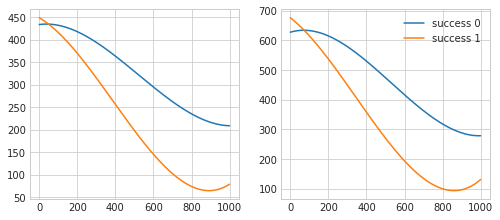

In [241]:
# #Visualize fitted params across success / failed trials
# init_dist = 1
# coefs = [f'b{i}' for i in range(1, m+1)]
# coefs_sum_str = '+'.join(coefs)
# res = smf.logit(f'success ~ {coefs_sum_str}', rdfs[init_dist]).fit()
# print(np.exp(res.params))
# print(res.summary())

# a = rdfs[init_dist].groupby('success').mean()
# plt.plot(a.loc[0, coefs], color='red')
# plt.plot(a.loc[1, coefs], color='green')
# plt.tick_params(rotation=45)

rc = {'axes.labelsize': 12}
with plt.rc_context(rc):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=[8.25, 3.5], squeeze=False)
    
    for i, init_dist in enumerate([1, 2]):
        for j, success in enumerate([0, 1]):
            filtered = rdf.loc[rdf.success.eq(success) & rdf.init_dist_cond.eq(init_dist), :]
            preds = []
            for k, (_, r) in enumerate(filtered.iterrows()):
                preds.append(r['mod'].predict(poly_data(np.arange(1000), m)))
            arr = np.stack(preds, axis=0)
            
            # Plot data
            y = np.mean(arr, axis=0)
            ax[0, i].plot(y, label=f'success {success}')
plt.legend()

## Task proximity dataframe

In [251]:
def proxi_comp(r, ideal_trajs):
    funcs = {'ed': euclidean, 'cos': cosine}
    vals, ind = [], []
    for k, f in funcs.items():
        for stat_measure in ['mean', 'median']:
            vals.append(f(r.traj_params[1:], ideal_trajs[r.init_dist_cond][stat_measure][1:]))
            ind.append(f'{k}2{stat_measure}')
    return pd.Series(vals, index=ind)


def get_ideal_trajs(df):
    r = {1: {}, 2: {}}
    for k in r.keys():
        trajs = np.stack(df.loc[df.success.eq(1) & df.init_dist_cond.eq(k), 'traj_params'].values)
        r[k]['median'] = np.median(trajs, 0)
        r[k]['mean'] = np.mean(trajs, 0)
    return r

# Add final success rate to each participant
prox_df = rdf.drop(columns=['mod'])
prox_df['sr'] = prox_df.groupby('participant').success.transform('mean')

# Calculate distance to ideal performance for each trajectory (separately for init_distance_cond's)
ideal_trajs = get_ideal_trajs(prox_df)
prox_df = pd.concat([prox_df, prox_df.apply(proxi_comp, axis=1, ideal_trajs=ideal_trajs)], axis=1)

disp(prox_df.head())



,participant,session,trial,init_dist_cond,success,traj_params,sr,ed2mean,ed2median,cos2mean,cos2median
0,8rtzammz@enigmind.anonaddy.me,1,1,2,0,"[432.7508014052465, 187.3841007644637, -951.77...",0.508772,744.622536,654.415989,0.115146,0.076533
1,8rtzammz@enigmind.anonaddy.me,1,2,1,0,"[273.6778022341271, 54.5704873195689, -416.620...",0.508772,222.323315,173.877680,0.047405,0.030000
2,8rtzammz@enigmind.anonaddy.me,1,3,2,1,"[357.6497262355987, 33.915010794713425, -668.9...",0.508772,392.472558,302.880333,0.062516,0.034817
3,8rtzammz@enigmind.anonaddy.me,1,4,1,0,"[252.7662266744035, 84.91495042744967, -325.60...",0.508772,187.711909,179.423002,0.138056,0.107696
4,8rtzammz@enigmind.anonaddy.me,1,5,2,0,"[523.1073328015488, 167.53333832058416, -587.0...",0.508772,391.152681,336.801813,0.180480,0.132629


# Summarize WAD and AS

,date,participant,session,trial,wind,init_site,plat_site,init_dist,end_dist,x_trail,...,init_dist_cond,success,wad,fas,wahs,wavs,was,ahs_end,avs_end,as_end
0,11/03 23:57:25,catlyn,2,38,1.24,1,0,496.52,156.41,"300,300,300,300,300,300,300,300,301,301,301,30...",...,1,0,432.942948,13.331966,12.613271,12.429391,18.064287,13.369099,12.334764,18.568557
1,11/03 23:57:15,catlyn,2,37,-3.03,1,2,347.88,32.24,"418,418,418,418,418,418,418,417,417,417,417,41...",...,1,0,141.251324,9.453952,8.097847,3.489005,9.170554,7.321995,3.315193,8.371703
2,11/03 23:56:56,catlyn,2,36,2.85,1,0,443.22,11.80,"369,369,369,369,369,369,369,369,368,368,368,36...",...,1,1,127.151301,6.973257,3.420070,5.408648,6.677155,3.077348,5.792818,6.684747
3,11/03 23:56:41,catlyn,2,35,0.08,0,2,495.12,25.41,"225,225,225,225,225,224,224,224,223,223,223,22...",...,2,0,255.602840,15.603590,12.067190,11.634116,18.581877,14.850174,11.432056,20.386828
4,11/03 23:56:29,catlyn,2,34,-0.74,1,0,499.66,9.42,"472,472,472,472,472,472,472,471,471,471,471,47...",...,1,1,90.336956,7.325178,3.971032,3.899040,5.900817,2.862222,2.635556,4.276922


<AxesSubplot:xlabel='fas', ylabel='Probability'>

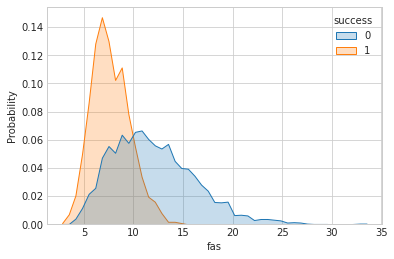

In [321]:
# Summarize trials
def summarize_trial(row):
    # For each frame compute signed 1-d distances from platform
    s_x = np.array(row.x_trail.split(',')).astype(int)
    s_y = np.array(row.y_trail.split(',')).astype(int)

    d_x = s_x - row.plat_x
    d_y = s_y - row.plat_y

    # # For each frame compute Euclidean distances to platform
    d = np.sqrt(d_x**2 + d_y**2)

    # # Flat-average summary of distances
    # row['fad'] = np.mean(d)

    # Weighted-average summary of distances
    relative_weights = np.arange(1, d.size + 1)
    row['wad'] = np.sum(d * (relative_weights/np.sum(relative_weights)))

    # Speed
    v_x = np.array(row.x_displ.split(',')).astype(int)
    v_y = np.array(row.y_displ.split(',')).astype(int)
    v = np.sqrt(v_x**2 + v_y**2)
    row['fas'] = np.mean(v)

    # Weighted-average summary of speeds
    relative_weights = np.arange(1, v_x.size + 1)
    row['wahs'] = np.sum(v_x * (relative_weights/np.sum(relative_weights)))
    row['wavs'] = np.sum(v_y * (relative_weights/np.sum(relative_weights)))
    row['was'] = np.sum(v * (relative_weights/np.sum(relative_weights)))

    i = v_y.size//2
    row['ahs_end'] = np.mean(v_x[-i:])
    row['avs_end'] = np.mean(v_y[-i:])
    row['as_end'] = np.mean(v[-i:])

    return row


# Summarize trial trajectories
st_df = df.apply(summarize_trial, axis=1)
st_df = st_df.drop(columns=['y_trail', 'plat_x', 'plat_y', 'x_displ', 'y_displ'])
# sign = 2 * st_df.outcome.str.contains('success').astype(int) - 1
# st_df = st_df.assign(
#     cwad = st_df.wad * sign,
#     cfad = st_df.fad * sign
# )

disp(st_df.head())

sns.histplot(x='fas', hue='success', stat='probability', element='poly', common_norm=False, common_bins=True, data=st_df)

In [322]:
# Summarize sessions
def summarize_session(sess):
    summary = {}
    trial = sess.trial
    half = trial.size // 2

    # Slopes
    for m in ['wad', 'was']: #'wad','fad','fahs','favs','wahs','wavs']:
        slope = smf.ols(f'{m} ~ trial', data=sess).fit().params['trial']
        summary[f'{m}Slope'] = slope

        summary[f'{m}Diff'] = np.mean(sess[f'{m}'][half:]) - np.mean(sess[f'{m}'][-half:])

    # Slope (of log-odds) for success probability
    summary['sr'] = np.mean(sess.success)
    summary['srd'] = np.mean(sess.success[-half:]) - np.mean(sess.success[:half])

    # Means of the second half of session
    # summary['wadMeanRecent'] = np.mean(sess.wad[half:])
    summary['pressesMeanRecent'] = np.mean(sess.presses[half:])
    summary['successRateRecent'] = np.mean(sess.success[half:])

    
    
    return pd.Series(summary.values(), index=summary.keys())


# Summarize session data
ss_df = st_df.set_index(['participant','session','forced'])
ss_df = ss_df.sort_values(by=['participant','session','forced','trial'])
ss_df = ss_df.groupby(['participant','session','forced']).apply(summarize_session).reset_index()

disp(ss_df.head())


,participant,session,forced,wadSlope,wadDiff,wasSlope,wasDiff,sr,srd,pressesMeanRecent,successRateRecent
0,8rtzammz@enigmind.anonaddy.me,1,True,-1.718399,0.000000,-0.115099,0.000000,0.220000,0.120000,41.7600,0.28000
1,8rtzammz@enigmind.anonaddy.me,2,True,-0.141700,0.000000,0.026265,0.000000,0.734375,0.093750,31.0625,0.78125
2,Alex,1,True,-16.027958,0.000000,-0.275151,0.000000,0.000000,0.000000,14.6000,0.00000
3,Amaury,1,True,-1.552497,0.444362,-0.083549,-0.080594,0.349206,0.193548,33.7500,0.43750
4,Arkemousse,1,False,15.336889,17.001117,-0.949727,0.076004,0.000000,0.000000,9.2000,0.00000


# Correlation with JOLDs

0.26 rows are missing jold-8 ratings


,participant,session,forced,wadSlope,wadDiff,wasSlope,wasDiff,sr,srd,pressesMeanRecent,successRateRecent,jold_R,jold_P
0,8rtzammz@enigmind.anonaddy.me,1,True,-1.718399,0.000000,-0.115099,0.000000,0.220000,0.120000,41.760000,0.280000,5.0,NaN
1,8rtzammz@enigmind.anonaddy.me,2,True,-0.141700,0.000000,0.026265,0.000000,0.734375,0.093750,31.062500,0.781250,1.0,NaN
2,Amaury,1,True,-1.552497,0.444362,-0.083549,-0.080594,0.349206,0.193548,33.750000,0.437500,2.0,3.0
3,Arkemousse,1,False,15.336889,17.001117,-0.949727,0.076004,0.000000,0.000000,9.200000,0.000000,3.0,2.0
4,Arkemousse,1,True,-1.826863,0.000000,-0.092919,0.000000,0.052632,0.105263,22.631579,0.105263,3.0,2.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 jold_R   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                   0.01530
Date:                Tue, 28 Dec 2021   Prob (F-statistic):              0.985
Time:                        02:35:15   Log-Likelihood:                -212.50
No. Observations:                 108   AIC:                             431.0
Df Residuals:                     105   BIC:                             439.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7209      0.171     10.058      0.000       1.382       2.060
wasDiff       -0.0462      0.347     -0.133      0.894      -0.735       0.642
wadDiff        0.0025      0.016      0.161      0.872      -0.029       0.034
==============================================================================
Omnibus:                       10.134   Durbin-Watson:                   1.569
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               13.735
Skew:                          -0.471   Prob(JB):                      0.00104
Kurtosis:                       4.472   Cond. No.                         24.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

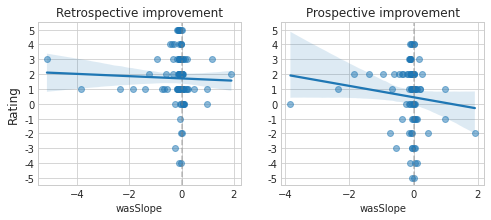

In [325]:
def summary(g):
    summary_dict = {}
    nt = g.shape[0]

    summary_dict['srd'] = np.mean(g.success[nt//2:]) - np.mean(g.success[:nt//2])

    # Slope of WAD scores
    for m in ['ed2mean', 'ed2median', 'cos2mean', 'cos2median']:
        slope = smf.ols(f'{m} ~ trial', data=g).fit().params['trial']
        # slope = np.mean(g.loc[:, m][nt//2:]) - np.mean(g.loc[:, m][:nt//2])
        summary_dict[f'{m}Slope'] = slope

    return pd.Series(summary_dict.values(), index=summary_dict.keys())

prox_df2 = prox_df.filter(items=['participant','session','init_dist_cond','success', 'trial', 'ed2mean', 'ed2median', 'cos2mean', 'cos2median'])
prox_df2 = prox_df2.groupby(['participant','session']).apply(summary)

ans_df = pd.read_csv('../data/clean/answers/clean_answers.csv', index_col=None)
jolds = ans_df.loc[ans_df.inst.eq('jold')].set_index(['participant', 'session']).sort_index()
jolds = jolds.loc[jolds.qid.eq(1) | jolds.qid.eq(8), :]
jolds = jolds.reset_index().drop(columns=['inst'])
jolds = jolds.pivot(index=['participant', 'session'], columns='qid', values='value') - 6
jolds = jolds.reset_index()
print(f'{jolds.loc[:, 8].isna().sum()/jolds.shape[0]:.2f} rows are missing jold-8 ratings')

df2merge = ss_df #prox_df2

mdf = df2merge.merge(jolds, on=['participant', 'session'])
mdf = mdf.rename(columns={1: 'jold_R', 8: 'jold_P'})

disp(mdf.head())

rc = {'axes.labelsize': 2, 'axes.titleweight': 'bold'}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[8, 3])

with plt.rc_context(rc):
    for i, judgment in enumerate(['jold_R', 'jold_P']):
        ax[i].axvline(0, color='gray', ls='--', alpha=.5)
        sns.regplot(x='wasSlope', y=judgment, data=mdf, ax=ax[i], scatter_kws=dict(alpha=.5))
        ax[i].set_ylim(-5.5, 5.5)
        ax[i].set_yticks(np.arange(-5, 6))
        ax[i].set_yticklabels(np.arange(-5, 6).astype(str))

# ax[0].set_xlabel('Success rate difference', fontsize=12)
# ax[1].set_xlabel('Success rate difference', fontsize=12)
ax[0].set_ylabel('Rating', fontsize=12)
ax[1].set_ylabel('', fontsize=12)
ax[0].set_title('Retrospective improvement', fontsize=12)
ax[1].set_title('Prospective improvement', fontsize=12)

m1 = smf.ols('jold_R ~ wasDiff + wadDiff', data=mdf).fit()
m1.summary()
# m3 = smf.ols('jold_P ~ jold_R + srd', data=mdf).fit()
# display(m1.summary())

# n_improvers = len(df.loc[df.sr.eq(0) & df.jold_R.gt(0), 'participant'].unique())
# n_total = len(df.participant.unique())
# print(f'{n_improvers}/{n_total} = {n_improvers/n_total} reported improvement without an increase in success rate')

# Normalized trajectories

In [ ]:
def normalized_distance_trajectories(df, n):
    return_dict = {'x': [], 'y': []}
    for _, r in df.iterrows():
        for d in 'xy':
            dist = np.abs(np.array(r[f'{d}_trail'].split(',')).astype(int) - r[f'plat_{d}'])
            if dist.size >= n:
                return_dict[d].append(
                    np.array([np.mean(_) for _ in np.array_split(dist, n)])
                )
            else:
                continue
    for k in return_dict.keys():
        return_dict[k] = np.stack(return_dict[k], axis=0)
    return return_dict


def normalized_speed_trajectories(df, n):
    return_dict = {'x': [], 'y': []}
    for _, r in df.iterrows():
        for d in 'xy':
            speed = np.array(r[f'{d}_displ'].split(',')).astype(int)
            if speed.size >= n:
                return_dict[d].append(
                    np.array([np.mean(_) for _ in np.array_split(speed, n)])
                )
            else:
                continue
    for k in return_dict.keys():
        return_dict[k] = np.stack(return_dict[k], axis=0)
    return return_dict


def normalized_tilt_trajectories(df, n):
    return_dict = {'x': []}
    for _, r in df.iterrows():
        z = + 0.0000001
        x_displ = np.array(r['x_displ'].split(',')).astype(int)
        y_displ = np.array(r['y_displ'].split(',')).astype(int)
        tilt = np.degrees(np.arctan(y_displ+z/x_displ+z))
        tilt[np.logical_and(x_displ == 0, y_displ > 0)] = 0
        tilt[np.logical_and(x_displ == 0, y_displ == 0)] = 0
        if tilt.size >= n:
            return_dict['x'].append(
                np.array([np.mean(_) for _ in np.array_split(tilt, n)])
            )
        else:
            continue
    for k in return_dict.keys():
        return_dict[k] = np.stack(return_dict[k], axis=0)
    return return_dict 


# MAIN 
# =========================================================================
lstl = {0: '-', 1: ':'}
n = 100
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, figsize=[8, 7])
colors = {
    'Offscreen':'gray',
    'Crash': 'darkred',
    'Success': 'green'
}
x = np.arange(1, n+1)
varname2func_dict = {
    'Distance to platform': normalized_distance_trajectories,
    # 'Angle to platform': normalized_angle_trajectories,
    'Speed': normalized_speed_trajectories,
}
cols = ('y_trail','x_trail','plat_y','plat_x','x_displ','y_displ')
for i1, (var_name, func) in enumerate(varname2func_dict.items()):
    ymax = 0
    for i2, distance in enumerate([1, 2]):
        for i3, outcome in enumerate(['Offscreen','Crash', 'Success']):
            filt = np.abs(df.init_site - df.plat_site) == distance
            filt = filt & df.outcome.eq(outcome.lower())
            filtered = df.loc[filt, cols]
            ndt = func(filtered, n=n)
            for i4, d in enumerate('xy'):
                if d in ndt.keys():
                    m = np.mean(ndt[d], axis=0)
                    ci = ci95(ndt[d])
                    ax[i1, i2].plot(x, m, c=colors[outcome], ls=lstl[i4])
                    ax[i1, i2].fill_between(x, ci[0], ci[1], alpha=.1, color=colors[outcome])
                    # ax[i4, i2].set_ylim(0, 50)
                    ax[i1, i2].set_xlim(x.min(), x.max())
                    ymax = max(ci.max(), ymax)
    for ax_i in ax[i1, :]: ax_i.set_ylim(0, ymax)
    ax[i1, 0].set_ylabel(var_name)

# Legends and annotations
ax[0, 0].set_title('Start close')
ax[0, 1].set_title('Start far')
ax[-1, 0].set_xlabel('Episode fragment')
ax[-1, 1].set_xlabel('Episode fragment')
outcome_lines = [line(k, c=v) for k, v in colors.items()]
direction_lines = [line('Horizontal', c='k', ls='-'), line('Vertical', c='k', ls=':')]
ax[0, 0].legend(handles = outcome_lines + direction_lines)

# Report number of episodes with less than `n` frames
less_than_n = (df.x_trail.str.count(',') < n).sum()
total = df.shape[0]
pless = less_than_n/total
print(f'{less_than_n}/{total} = {pless}% of trials are less than {n} frames')

plt.savefig(f'../figs/dist_speed_norm_{n}.pdf')

# WAD and AS measures

# Spare cells

<AxesSubplot:xlabel='cos2mean', ylabel='Probability'>

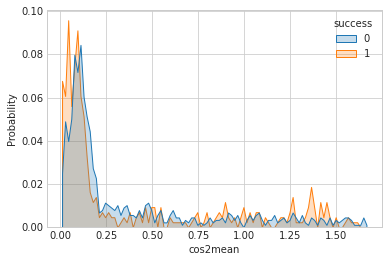